In [1]:
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from utils.utils import eval_dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("D:\Datasets\cardiovascular\cardio.csv",sep=";")
data = data.drop(columns=['id'])
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0,0.0
1,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0,1.0
2,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0,1.0
3,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0,1.0
4,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
target = 'cardio'

In [5]:
X = data.drop(columns=[target])
#normalize data
#X=(X-X.mean())/X.std()
y = data[target]

In [6]:
dpctgan = DPCTGANSynthesizer(verbose=True,
                            epochs=1,
                            clip_coeff=0.1,
                            sigma=4,
                            target_epsilon=4,
                            target_delta=1e-5
                            )
dpctgan.fit(data)

Init CTGAN with differential privacy.  Target epsilon: 4
Epoch 1, Loss G:  0.4882, Loss D: -0.2231, Epsilon: 0.1130
Epoch 2, Loss G:  0.1158, Loss D: -0.0217, Epsilon: 0.1516
Epoch 3, Loss G: -0.5079, Loss D:  0.2400, Epsilon: 0.1846
Epoch 4, Loss G: -0.4861, Loss D:  0.2322, Epsilon: 0.2124
Epoch 5, Loss G: -0.2727, Loss D:  0.0233, Epsilon: 0.2369
Epoch 6, Loss G: -0.6111, Loss D: -0.0513, Epsilon: 0.2591
Epoch 7, Loss G: -0.1521, Loss D:  0.0092, Epsilon: 0.2796
Epoch 8, Loss G: -0.0438, Loss D: -0.0122, Epsilon: 0.2986
Epoch 9, Loss G: -0.2623, Loss D:  0.1272, Epsilon: 0.3165
Epoch 10, Loss G:  0.1082, Loss D: -0.0054, Epsilon: 0.3334
Epoch 11, Loss G: -0.4337, Loss D:  0.0846, Epsilon: 0.3496
Epoch 12, Loss G:  0.2628, Loss D: -0.2387, Epsilon: 0.3650
Epoch 13, Loss G:  0.2685, Loss D: -0.2847, Epsilon: 0.3798
Epoch 14, Loss G:  0.1741, Loss D:  0.1090, Epsilon: 0.3940
Epoch 15, Loss G:  0.2017, Loss D:  0.1051, Epsilon: 0.4078
Epoch 16, Loss G: -0.1214, Loss D: -0.0951, Epsilon:

KeyboardInterrupt: 

In [7]:
samples = dpctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

In [ ]:
#normalized_samples=(samples-samples.min())/(samples.max()-samples.min())

## Privacy

In [8]:
import numpy as np

def get_nearest(src_point, candidates):
    min_dist = 1000
    min_index = 0
    for i in range(len(candidates)):
        dist = np.linalg.norm(src_point - candidates.iloc[[i]])
        print(candidates.iloc[[i]])
        print("{:.2f}".format(dist))
        if dist < min_dist:
            min_dist = dist
            min_index = i

    return min_index, min_dist

In [9]:
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1):
    '''
    Find nearest neighbors for all source points from a set of candidate points
    '''
    # Create tree from the candidate points
    #knn = NearestNeighbors(n_neighbors=3)
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')
    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)
    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()
    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]
    # Return indices and distances
    return closest, closest_dist

In [10]:
def avg_dist(src_points, candidates):
    sum_dist = 0
    for i in range(len(src_points)):
        index, dist = get_nearest(src_points.iloc[[i]], candidates)
        sum_dist += dist
        
    return sum_dist/i 


In [11]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame

In [12]:
# example
closest, dist = get_nearest(samples.iloc[[0]], data)
print(closest, dist)

[26888] [0.02715757]


In [13]:
avg_distance = avg_dist(samples[:1000], data[:1000])

In [14]:
print(avg_distance)

[0.09908015]


In [15]:
# the maximum possible distance between two normalized vectors is sqrt(n), so you would divide the Euclidean distance between the two vectors by sqrt(n)
# Ex: 2D space, the maximum distance between two points is the square root of 2 
normalized_avg_distance = avg_distance/np.sqrt(len(data.columns))
print(normalized_avg_distance)

[0.02860198]


## Fidelity

In [16]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

def get_predictions(X_train, y_train, X_test, y_test):
    learners = [(AdaBoostClassifier(n_estimators=50))]
    #learners = [(RandomForestClassifier())]

    history = dict()

    for i in range(len(learners)):
        model = learners[i]
        model.fit(X_train, y_train)

        #first letter is data where it trained, second is data where it tested
        pred = []

        for j in range (len(X_test)):
            #print(X_test.loc[[j]])
            pred.append(model.predict(X_test.iloc[[j]]))
        
    return pred

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

In [18]:
rf_pred = get_predictions(X_train, y_train, X_syn_test, y_syn_test)
ff_pred = get_predictions(X_syn_train, y_syn_train, X_syn_test, y_syn_test)

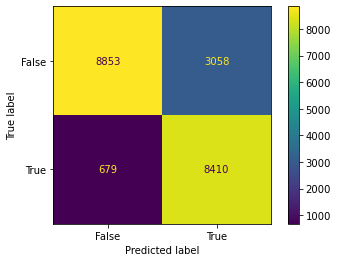

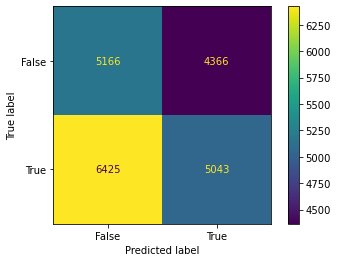

In [19]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred, rf_pred, ff_pred):
    confusion_matrix1 = metrics.confusion_matrix(rr_pred, fr_pred)
    confusion_matrix2 = metrics.confusion_matrix(fr_pred, ff_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1, display_labels = [False, True])
    cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = [False, True])

    cm_display1.plot()
    cm_display2.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred, rf_pred, ff_pred)

In [20]:
def eval_fidelity(pred1, pred2):
    same_pred = 0
    dif_pred = 0
    if len(pred1) != len(pred2):
        print("Error: different sizes")
    
    for i in range(len(pred1)):
        if pred1[i] == pred2[i]:
            same_pred += 1
        else:
            dif_pred += 1

    return same_pred, dif_pred


In [21]:
same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [22]:
print(same_pred, dif_pred)

17263 3737


In [23]:
percentage = same_pred / (same_pred + dif_pred)

## Final plot

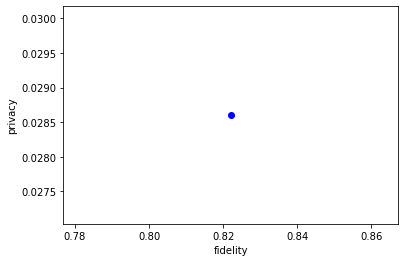

In [24]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()